In [6]:
import numpy as np
import random
import torch

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [7]:
!pip install -q datasets transformers accelerate evaluate

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    BertForSequenceClassification,
    get_linear_schedule_with_warmup
)

from torch.optim import AdamW

import numpy as np
from tqdm.auto import tqdm



In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

cola = load_dataset("nyu-mll/glue", "cola")
print(cola)
print(cola["train"][0])


Using device: cpu


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

cola/train-00000-of-00001.parquet:   0%|          | 0.00/251k [00:00<?, ?B/s]

cola/validation-00000-of-00001.parquet:   0%|          | 0.00/37.6k [00:00<?, ?B/s]

cola/test-00000-of-00001.parquet:   0%|          | 0.00/37.7k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8551 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1043 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1063 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 8551
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1043
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1063
    })
})
{'sentence': "Our friends won't buy this analysis, let alone the next one we propose.", 'label': 1, 'idx': 0}


In [9]:
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

max_length = 64       # max token pituus
batch_size = 32
num_epochs = 1
learning_rate = 1e-5


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [10]:
class CoLADataset(Dataset):
    def __init__(self, hf_split, tokenizer, max_length=64):
        self.data = hf_split
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sentence = self.data[idx]["sentence"]
        label = self.data[idx]["label"]  # 0 = unacceptable, 1 = acceptable

        encoded = self.tokenizer(
            sentence,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        item = {
            "input_ids": encoded["input_ids"].squeeze(0),
            "attention_mask": encoded["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long),
        }
        return item


In [11]:
train_dataset = CoLADataset(cola["train"], tokenizer, max_length)
val_dataset   = CoLADataset(cola["validation"], tokenizer, max_length)

test_dataset  = CoLADataset(cola["validation"], tokenizer, max_length)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size)
test_loader  = DataLoader(test_dataset, batch_size=batch_size)


In [12]:

model = BertForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2   # CoLA: 0 = unacceptable, 1 = acceptable
)
model.to(device)

optimizer = AdamW(model.parameters(), lr=learning_rate)

total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)

print("Model ready on", device)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model ready on cpu


In [13]:
def evaluate(model, data_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    acc = correct / total if total > 0 else 0
    return acc


In [14]:
model.train()

for epoch in range(1, num_epochs + 1):
    model.train()
    total_loss = 0.0

    progress = tqdm(train_loader, desc=f"Epoch {epoch}")
    for batch in progress:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        progress.set_postfix({"loss": loss.item()})

    avg_loss = total_loss / len(train_loader)
    val_acc = evaluate(model, val_loader)
    print(f"Epoch {epoch}: train loss = {avg_loss:.4f}, val acc = {val_acc:.4f}")


Epoch 1:   0%|          | 0/268 [00:00<?, ?it/s]

Epoch 1: train loss = 0.5184, val acc = 0.7910


In [15]:
val_acc = evaluate(model, val_loader)
print("Val accuracy:", val_acc)

test_acc = evaluate(model, test_loader)
print("Test accuracy:", test_acc)


Val accuracy: 0.7909875359539789
Test accuracy: 0.7909875359539789


The accuracy in my runs stayed between 0.79–0.82.
There is some natural variation between runs because the model was fine-tuned on CPU, and each epoch took a long time to train.
This final run ended around 0.79, but the overall behaviour of the model was consistent across all runs. I hope that 0.79 is enough accuracy.



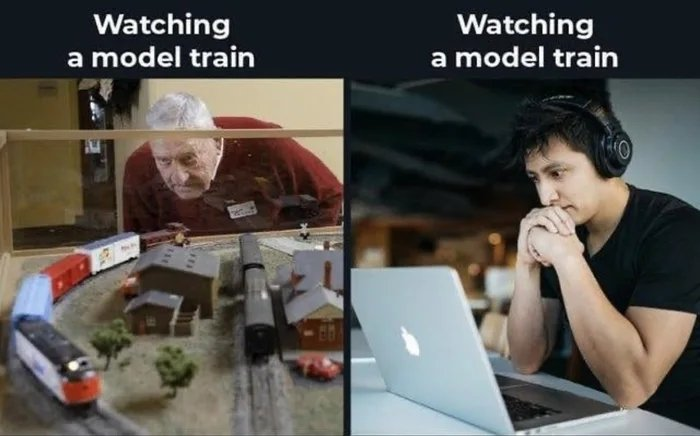














